In [1]:
import os
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as tt
from PIL import Image
import torch
import torch.nn as nn
import cv2
import numpy as np
from tqdm.notebook import tqdm
import torch.nn.functional as F
from torchvision.utils import save_image
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import torchvision.utils as vutils

In [2]:
def get_stats(loader):
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
    for data in loader:
        channels_sum += torch.mean(data,dim=[0,2,3])
        channels_squared_sum += torch.mean(data**2,dim=[0,2,3])
        num_batches += 1
    mean = channels_sum/num_batches
    std = (channels_squared_sum/num_batches)**0.5
    return mean, std

In [3]:
def load_checkpoint(checkpoint_path, generator, discriminator, opt_g, opt_d):
    checkpoint = torch.load(checkpoint_path)
    epoch = checkpoint["epoch"]
    generator.load_state_dict(checkpoint["generator_state_dict"])
    discriminator.load_state_dict(checkpoint["discriminator_state_dict"])
    opt_g.load_state_dict(checkpoint["opt_g_state_dict"])
    opt_d.load_state_dict(checkpoint["opt_d_state_dict"])
    losses_g = checkpoint["losses_g"]
    losses_d = checkpoint["losses_d"]
    real_scores = checkpoint["real_scores"]
    fake_scores = checkpoint["fake_scores"]

    return epoch, generator, discriminator, opt_g, opt_d, losses_g, losses_d, real_scores, fake_scores

In [4]:
image_size = (128,128)
batch_size = 64
dataset_dir = '/kaggle/input/landscape-pictures'

In [5]:
def preprocess_image(image):
    transform=tt.Compose([
        tt.Resize(image_size),
        tt.ToTensor(),
        tt.Normalize([0.4437, 0.4712, 0.4613], [0.5163, 0.5334, 0.5474])
    ])
    return transform(image)

In [6]:
class LandscapeDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.image_files = os.listdir(root_dir)

    def __len__(self):
        return len(self.image_files)
        
    def __getitem__(self, idx):
        image_path = os.path.join(self.root_dir, self.image_files[idx])
        image = Image.open(image_path)
        image = image.convert("RGB")
        image = preprocess_image(image)
        return image

In [7]:
dataset = LandscapeDataset('/kaggle/input/landscape-pictures')
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [8]:
#get_stats(dataloader)

In [9]:
def is_cuda_available():
    if torch.cuda.is_available():
        print("CUDA available. Training on GPU!")
        return torch.device('cuda')
    else:
        print("CUDA not available. Training on CPU!")
        return torch.device('cpu')

In [10]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [11]:
device = is_cuda_available()
dataloader = DeviceDataLoader(dataloader, device)

CUDA available. Training on GPU!


In [12]:
discriminator = nn.Sequential(
    # in: 3 x 128 x 128

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 64 x 64

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 32 x 32

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 16 x 16

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 8 x 8
    
    
    nn.Conv2d(512, 1024, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(1024),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 1024 x 4 x 4

    nn.Conv2d(1024, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [13]:
latent_size = 256
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 1024, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(1024),
    nn.ReLU(True),
    # out: 1024 x 4 x 4

    nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 8 x 8

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 16 x 16

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 32 x 32

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 64 x 64
    
    
    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()

)

In [14]:
discriminator = to_device(discriminator, device)
generator = to_device(generator, device)

In [15]:
def train_discriminator(discriminator,real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [16]:
def train_generator(generator,opt_g):
    # Clear generator gradients
    opt_g.zero_grad()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)

    # Update generator weights
    loss.backward()
    opt_g.step()

    return loss.item()

In [17]:
fixed_latent = torch.randn(4, latent_size, 1, 1, device=device)

In [18]:
def show_samples(latent_tensors):
    fake_images = generator(latent_tensors)
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

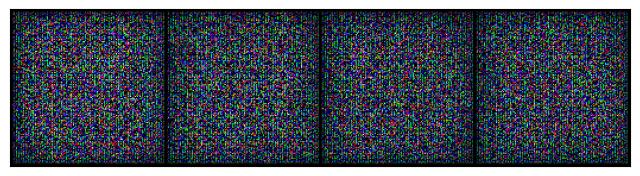

In [19]:
show_samples(fixed_latent)

In [20]:
def save_images(images, epoch, save_path='images'):
    """
    Save a set of images generated by the GAN.

    Parameters:
    - images: Tensor containing the generated images.
    - epoch: Current epoch number for naming the saved images.
    - save_path: Directory where images will be saved.
    """
    if not os.path.exists(save_path):
        os.makedirs(save_path)

    # Save 4 images in a 2x2 grid
    vutils.save_image(images, f'{save_path}/generated_epoch_{epoch}.png', normalize=True, nrow=2)

In [30]:
def make_video(image_folder, output_path='generated_video.avi', fps=5):
    """
    Create a video from a set of images.

    Parameters:
    - image_folder: Path to the directory containing the images.
    - output_path: Path to save the generated video.
    - fps: Frames per second for the video.
    """
    images = [img for img in sorted(os.listdir(image_folder),key=lambda x: int(x.split('_')[-1].split('.')[0])) if img.endswith(".png")]
    images.sort()

    frame = cv2.imread(os.path.join(image_folder, images[0]))
    height, width, layers = frame.shape

    video = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'DIVX'), fps, (width, height))

    for image in images:
        video.write(cv2.imread(os.path.join(image_folder, image)))

    video.release()

In [22]:
def fit(epochs, lr, start_idx=1):
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    global discriminator
    global generator
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

    for epoch in range(epochs):
        for real_images in tqdm(dataloader):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(discriminator,real_images, opt_d)
            # Train generator
            loss_g = train_generator(generator,opt_g)

        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        #save_samples(fixed_latent)
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
            
        img = generator(fixed_latent)
            
        save_images(img, epoch)
    return losses_g, losses_d, real_scores, fake_scores

In [23]:
lr = 0.0002
epochs = 200

In [24]:
history=fit(epochs,lr,'/kaggle/working/checkpoints/')

  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [1/200], loss_g: 9.7713, loss_d: 0.7500, real_score: 0.8972, fake_score: 0.3862


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [2/200], loss_g: 5.4436, loss_d: 0.0938, real_score: 0.9485, fake_score: 0.0366


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [3/200], loss_g: 10.9902, loss_d: 3.8755, real_score: 0.9813, fake_score: 0.9704


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [4/200], loss_g: 0.9714, loss_d: 0.8817, real_score: 0.6324, fake_score: 0.2449


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [5/200], loss_g: 1.4597, loss_d: 0.9237, real_score: 0.5608, fake_score: 0.2389


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [6/200], loss_g: 3.7378, loss_d: 1.6172, real_score: 0.9647, fake_score: 0.7385


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [7/200], loss_g: 1.0402, loss_d: 1.0413, real_score: 0.4677, fake_score: 0.1446


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [8/200], loss_g: 3.2410, loss_d: 0.9941, real_score: 0.9260, fake_score: 0.5598


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [9/200], loss_g: 5.0247, loss_d: 1.9900, real_score: 0.9031, fake_score: 0.8073


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [10/200], loss_g: 2.2253, loss_d: 0.7544, real_score: 0.6268, fake_score: 0.1375


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [11/200], loss_g: 4.3391, loss_d: 0.8389, real_score: 0.8245, fake_score: 0.4351


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [12/200], loss_g: 4.2019, loss_d: 0.8059, real_score: 0.8025, fake_score: 0.4079


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [13/200], loss_g: 2.8159, loss_d: 0.7818, real_score: 0.8697, fake_score: 0.4282


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [14/200], loss_g: 2.4561, loss_d: 1.2750, real_score: 0.3831, fake_score: 0.0488


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [15/200], loss_g: 2.0950, loss_d: 1.7916, real_score: 0.2373, fake_score: 0.0099


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [16/200], loss_g: 4.1776, loss_d: 0.9437, real_score: 0.9537, fake_score: 0.5240


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [17/200], loss_g: 2.0943, loss_d: 2.3930, real_score: 0.2315, fake_score: 0.2916


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [18/200], loss_g: 5.5702, loss_d: 0.7414, real_score: 0.9061, fake_score: 0.4310


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [19/200], loss_g: 2.3860, loss_d: 0.8688, real_score: 0.5122, fake_score: 0.0401


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [20/200], loss_g: 5.1845, loss_d: 0.7171, real_score: 0.8503, fake_score: 0.3864


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [21/200], loss_g: 4.2546, loss_d: 0.3672, real_score: 0.8470, fake_score: 0.1647


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [22/200], loss_g: 2.2002, loss_d: 1.4211, real_score: 0.3238, fake_score: 0.0162


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [23/200], loss_g: 3.9826, loss_d: 0.9389, real_score: 0.4656, fake_score: 0.0098


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [24/200], loss_g: 4.8129, loss_d: 0.8654, real_score: 0.7789, fake_score: 0.3663


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [25/200], loss_g: 5.8371, loss_d: 0.4934, real_score: 0.9497, fake_score: 0.3283


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [26/200], loss_g: 1.7506, loss_d: 0.9052, real_score: 0.4861, fake_score: 0.0166


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [27/200], loss_g: 5.9954, loss_d: 0.5821, real_score: 0.6203, fake_score: 0.0181


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [28/200], loss_g: 3.7429, loss_d: 0.3424, real_score: 0.8632, fake_score: 0.1626


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [29/200], loss_g: 2.3285, loss_d: 1.1532, real_score: 0.4941, fake_score: 0.2634


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [30/200], loss_g: 5.8910, loss_d: 0.7620, real_score: 0.9880, fake_score: 0.4725


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [31/200], loss_g: 7.1774, loss_d: 0.1606, real_score: 0.9243, fake_score: 0.0716


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [32/200], loss_g: 1.6710, loss_d: 0.6699, real_score: 0.6131, fake_score: 0.0934


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [33/200], loss_g: 3.0956, loss_d: 0.4496, real_score: 0.7273, fake_score: 0.0562


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [34/200], loss_g: 5.1891, loss_d: 0.1902, real_score: 0.8464, fake_score: 0.0101


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [35/200], loss_g: 0.4637, loss_d: 1.6333, real_score: 0.4077, fake_score: 0.0891


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [36/200], loss_g: 2.6643, loss_d: 0.2214, real_score: 0.8517, fake_score: 0.0494


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [37/200], loss_g: 1.4501, loss_d: 0.6163, real_score: 0.6566, fake_score: 0.1027


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [38/200], loss_g: 4.3212, loss_d: 0.2571, real_score: 0.9077, fake_score: 0.1299


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [39/200], loss_g: 4.1408, loss_d: 0.4980, real_score: 0.9584, fake_score: 0.2697


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [40/200], loss_g: 6.0673, loss_d: 0.1012, real_score: 0.9613, fake_score: 0.0545


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [41/200], loss_g: 1.9336, loss_d: 0.5708, real_score: 0.6811, fake_score: 0.1204


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [42/200], loss_g: 9.1106, loss_d: 1.4811, real_score: 0.9682, fake_score: 0.6674


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [43/200], loss_g: 7.6503, loss_d: 0.3756, real_score: 0.9506, fake_score: 0.2483


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [44/200], loss_g: 4.8927, loss_d: 0.1215, real_score: 0.9390, fake_score: 0.0536


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [45/200], loss_g: 1.6032, loss_d: 0.7423, real_score: 0.5757, fake_score: 0.0569


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [46/200], loss_g: 8.9970, loss_d: 1.1191, real_score: 0.9196, fake_score: 0.5593


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [47/200], loss_g: 4.1698, loss_d: 0.1653, real_score: 0.9100, fake_score: 0.0571


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [48/200], loss_g: 0.0647, loss_d: 1.6041, real_score: 0.2756, fake_score: 0.0082


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [49/200], loss_g: 6.0448, loss_d: 0.2337, real_score: 0.9728, fake_score: 0.1680


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [50/200], loss_g: 3.5988, loss_d: 0.6924, real_score: 0.5614, fake_score: 0.0217


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [51/200], loss_g: 1.7989, loss_d: 0.5285, real_score: 0.6540, fake_score: 0.0240


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [52/200], loss_g: 4.5925, loss_d: 0.3351, real_score: 0.9094, fake_score: 0.1947


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [53/200], loss_g: 4.5141, loss_d: 0.3350, real_score: 0.8091, fake_score: 0.0801


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [54/200], loss_g: 8.1401, loss_d: 0.8439, real_score: 0.9587, fake_score: 0.4600


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [55/200], loss_g: 5.4904, loss_d: 0.1835, real_score: 0.9208, fake_score: 0.0880


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [56/200], loss_g: 0.5232, loss_d: 1.7339, real_score: 0.2789, fake_score: 0.0054


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [57/200], loss_g: 3.1997, loss_d: 0.2714, real_score: 0.8811, fake_score: 0.1165


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [58/200], loss_g: 2.3805, loss_d: 0.5649, real_score: 0.6673, fake_score: 0.0747


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [59/200], loss_g: 0.0912, loss_d: 2.1073, real_score: 0.1812, fake_score: 0.0047


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [60/200], loss_g: 0.6080, loss_d: 0.8333, real_score: 0.5037, fake_score: 0.0133


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [61/200], loss_g: 5.7846, loss_d: 0.8032, real_score: 0.8965, fake_score: 0.4189


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [62/200], loss_g: 0.3307, loss_d: 3.1359, real_score: 0.0901, fake_score: 0.0062


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [63/200], loss_g: 5.2570, loss_d: 0.2329, real_score: 0.9026, fake_score: 0.0799


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [64/200], loss_g: 5.3676, loss_d: 0.0865, real_score: 0.9747, fake_score: 0.0539


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [65/200], loss_g: 3.5078, loss_d: 0.0468, real_score: 0.9767, fake_score: 0.0212


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [66/200], loss_g: 2.8996, loss_d: 0.5830, real_score: 0.6753, fake_score: 0.0563


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [67/200], loss_g: 4.0132, loss_d: 0.1326, real_score: 0.8990, fake_score: 0.0185


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [68/200], loss_g: 3.1412, loss_d: 0.2803, real_score: 0.8342, fake_score: 0.0608


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [69/200], loss_g: 5.8013, loss_d: 0.2004, real_score: 0.8481, fake_score: 0.0021


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [70/200], loss_g: 0.9850, loss_d: 0.7253, real_score: 0.5800, fake_score: 0.0279


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [71/200], loss_g: 5.9242, loss_d: 0.6663, real_score: 0.8807, fake_score: 0.3404


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [72/200], loss_g: 5.4054, loss_d: 0.2242, real_score: 0.9302, fake_score: 0.1167


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [73/200], loss_g: 4.0596, loss_d: 0.0834, real_score: 0.9604, fake_score: 0.0400


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [74/200], loss_g: 4.7407, loss_d: 0.3639, real_score: 0.7615, fake_score: 0.0259


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [75/200], loss_g: 6.3326, loss_d: 0.0647, real_score: 0.9594, fake_score: 0.0199


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [76/200], loss_g: 5.3440, loss_d: 0.3016, real_score: 0.9945, fake_score: 0.2109


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [77/200], loss_g: 1.0498, loss_d: 0.9730, real_score: 0.4737, fake_score: 0.0155


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [78/200], loss_g: 5.9121, loss_d: 1.3939, real_score: 0.3917, fake_score: 0.0009


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [79/200], loss_g: 5.3631, loss_d: 0.2073, real_score: 0.9790, fake_score: 0.1520


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [80/200], loss_g: 3.7429, loss_d: 0.0900, real_score: 0.9752, fake_score: 0.0588


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [81/200], loss_g: 2.5672, loss_d: 0.3541, real_score: 0.8115, fake_score: 0.0628


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [82/200], loss_g: 4.0321, loss_d: 0.1324, real_score: 0.9731, fake_score: 0.0950


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [83/200], loss_g: 3.3798, loss_d: 0.3826, real_score: 0.8106, fake_score: 0.1106


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [84/200], loss_g: 4.7256, loss_d: 0.0792, real_score: 0.9546, fake_score: 0.0275


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [85/200], loss_g: 6.6395, loss_d: 0.0634, real_score: 0.9772, fake_score: 0.0366


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [86/200], loss_g: 8.8561, loss_d: 0.7780, real_score: 0.9957, fake_score: 0.4485


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [87/200], loss_g: 1.8607, loss_d: 0.2744, real_score: 0.7990, fake_score: 0.0238


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [88/200], loss_g: 5.2639, loss_d: 0.1755, real_score: 0.9071, fake_score: 0.0538


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [89/200], loss_g: 3.7458, loss_d: 0.5371, real_score: 0.6563, fake_score: 0.0209


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [90/200], loss_g: 2.5095, loss_d: 0.1758, real_score: 0.8970, fake_score: 0.0357


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [91/200], loss_g: 3.5859, loss_d: 0.5602, real_score: 0.6348, fake_score: 0.0100


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [92/200], loss_g: 7.9521, loss_d: 0.1080, real_score: 0.9890, fake_score: 0.0784


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [93/200], loss_g: 4.7399, loss_d: 0.2795, real_score: 0.9154, fake_score: 0.1390


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [94/200], loss_g: 10.7984, loss_d: 0.0994, real_score: 0.9187, fake_score: 0.0038


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [95/200], loss_g: 7.5906, loss_d: 0.4667, real_score: 0.9971, fake_score: 0.3027


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [96/200], loss_g: 6.4993, loss_d: 0.1019, real_score: 0.9869, fake_score: 0.0748


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [97/200], loss_g: 6.1235, loss_d: 0.1052, real_score: 0.9953, fake_score: 0.0813


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [98/200], loss_g: 2.9597, loss_d: 0.3177, real_score: 0.8366, fake_score: 0.0113


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [99/200], loss_g: 5.4356, loss_d: 0.0333, real_score: 0.9752, fake_score: 0.0077


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [100/200], loss_g: 5.9779, loss_d: 0.0290, real_score: 0.9761, fake_score: 0.0040


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [101/200], loss_g: 2.6836, loss_d: 0.2153, real_score: 0.8793, fake_score: 0.0466


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [102/200], loss_g: 4.4384, loss_d: 0.0601, real_score: 0.9617, fake_score: 0.0189


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [103/200], loss_g: 4.9424, loss_d: 0.0703, real_score: 0.9402, fake_score: 0.0037


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [104/200], loss_g: 5.3303, loss_d: 0.1252, real_score: 0.9938, fake_score: 0.0744


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [105/200], loss_g: 4.2794, loss_d: 0.1534, real_score: 0.8962, fake_score: 0.0307


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [106/200], loss_g: 3.5968, loss_d: 0.3008, real_score: 0.8363, fake_score: 0.0558


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [107/200], loss_g: 2.5445, loss_d: 0.4291, real_score: 0.7335, fake_score: 0.0497


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [108/200], loss_g: 6.5511, loss_d: 0.0157, real_score: 0.9955, fake_score: 0.0109


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [109/200], loss_g: 9.1443, loss_d: 0.0895, real_score: 0.9213, fake_score: 0.0022


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [110/200], loss_g: 6.0509, loss_d: 0.0754, real_score: 0.9838, fake_score: 0.0539


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [111/200], loss_g: 6.0945, loss_d: 0.1306, real_score: 0.9793, fake_score: 0.0862


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [112/200], loss_g: 1.5394, loss_d: 0.3805, real_score: 0.7272, fake_score: 0.0203


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [113/200], loss_g: 6.2010, loss_d: 0.0531, real_score: 0.9917, fake_score: 0.0419


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [114/200], loss_g: 7.0362, loss_d: 0.0701, real_score: 0.9629, fake_score: 0.0274


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [115/200], loss_g: 5.0676, loss_d: 0.1046, real_score: 0.9342, fake_score: 0.0147


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [116/200], loss_g: 7.3964, loss_d: 0.1131, real_score: 0.9844, fake_score: 0.0379


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [117/200], loss_g: 5.2672, loss_d: 0.1302, real_score: 0.9165, fake_score: 0.0161


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [118/200], loss_g: 6.6389, loss_d: 0.3574, real_score: 0.8444, fake_score: 0.0435


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [119/200], loss_g: 3.7848, loss_d: 0.3426, real_score: 0.7947, fake_score: 0.0228


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [120/200], loss_g: 7.8813, loss_d: 0.3573, real_score: 0.9309, fake_score: 0.1817


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [121/200], loss_g: 2.5069, loss_d: 0.2622, real_score: 0.8256, fake_score: 0.0427


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [122/200], loss_g: 4.4568, loss_d: 0.0577, real_score: 0.9977, fake_score: 0.0489


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [123/200], loss_g: 6.2034, loss_d: 0.0473, real_score: 0.9595, fake_score: 0.0041


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [124/200], loss_g: 5.2248, loss_d: 0.0433, real_score: 0.9911, fake_score: 0.0322


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [125/200], loss_g: 4.7600, loss_d: 0.2881, real_score: 0.8080, fake_score: 0.0138


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [126/200], loss_g: 8.5815, loss_d: 0.1905, real_score: 0.9895, fake_score: 0.1254


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [127/200], loss_g: 1.7916, loss_d: 0.6523, real_score: 0.6251, fake_score: 0.0398


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [128/200], loss_g: 1.1418, loss_d: 0.7311, real_score: 0.5888, fake_score: 0.0062


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [129/200], loss_g: 5.2930, loss_d: 0.0908, real_score: 0.9695, fake_score: 0.0515


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [130/200], loss_g: 5.6264, loss_d: 0.0676, real_score: 0.9807, fake_score: 0.0318


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [131/200], loss_g: 4.2355, loss_d: 0.0977, real_score: 0.9286, fake_score: 0.0176


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [132/200], loss_g: 6.0257, loss_d: 0.0493, real_score: 0.9847, fake_score: 0.0317


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [133/200], loss_g: 5.7837, loss_d: 0.0466, real_score: 0.9826, fake_score: 0.0265


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [134/200], loss_g: 5.5955, loss_d: 0.0118, real_score: 0.9990, fake_score: 0.0104


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [135/200], loss_g: 4.1179, loss_d: 0.1529, real_score: 0.9120, fake_score: 0.0403


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [136/200], loss_g: 5.8092, loss_d: 0.1154, real_score: 0.9494, fake_score: 0.0509


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [137/200], loss_g: 6.3219, loss_d: 0.1257, real_score: 0.9096, fake_score: 0.0104


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [138/200], loss_g: 4.1938, loss_d: 0.3194, real_score: 0.8288, fake_score: 0.0739


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [139/200], loss_g: 7.0480, loss_d: 0.1111, real_score: 0.9733, fake_score: 0.0678


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [140/200], loss_g: 9.5168, loss_d: 0.2335, real_score: 0.8453, fake_score: 0.0024


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [141/200], loss_g: 5.4323, loss_d: 0.0316, real_score: 0.9926, fake_score: 0.0224


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [142/200], loss_g: 5.7733, loss_d: 0.1103, real_score: 0.9598, fake_score: 0.0514


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [143/200], loss_g: 5.9502, loss_d: 0.0921, real_score: 0.9996, fake_score: 0.0307


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [144/200], loss_g: 6.0208, loss_d: 0.1137, real_score: 0.9059, fake_score: 0.0064


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [145/200], loss_g: 2.6264, loss_d: 0.9989, real_score: 0.5466, fake_score: 0.0221


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [146/200], loss_g: 6.1681, loss_d: 0.0779, real_score: 0.9390, fake_score: 0.0088


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [147/200], loss_g: 6.2692, loss_d: 0.2190, real_score: 0.9822, fake_score: 0.1411


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [148/200], loss_g: 4.7939, loss_d: 0.1048, real_score: 0.9779, fake_score: 0.0723


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [149/200], loss_g: 6.4881, loss_d: 0.1919, real_score: 0.8778, fake_score: 0.0190


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [150/200], loss_g: 6.7131, loss_d: 0.0667, real_score: 0.9635, fake_score: 0.0233


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [151/200], loss_g: 6.4147, loss_d: 0.0762, real_score: 0.9509, fake_score: 0.0190


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [152/200], loss_g: 4.4144, loss_d: 0.2142, real_score: 0.8433, fake_score: 0.0028


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [153/200], loss_g: 6.7767, loss_d: 0.1388, real_score: 0.9804, fake_score: 0.1023


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [154/200], loss_g: 7.9568, loss_d: 0.0454, real_score: 0.9981, fake_score: 0.0397


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [155/200], loss_g: 5.8701, loss_d: 0.0328, real_score: 0.9855, fake_score: 0.0172


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [156/200], loss_g: 6.6264, loss_d: 0.0266, real_score: 0.9841, fake_score: 0.0100


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [157/200], loss_g: 9.9840, loss_d: 0.0445, real_score: 0.9676, fake_score: 0.0023


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [158/200], loss_g: 8.3872, loss_d: 0.1032, real_score: 0.9992, fake_score: 0.0865


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [159/200], loss_g: 6.1909, loss_d: 0.0906, real_score: 0.9388, fake_score: 0.0190


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [160/200], loss_g: 9.4605, loss_d: 0.0117, real_score: 0.9999, fake_score: 0.0112


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [161/200], loss_g: 9.2034, loss_d: 0.1592, real_score: 0.9246, fake_score: 0.0497


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [162/200], loss_g: 4.4387, loss_d: 0.5845, real_score: 0.6951, fake_score: 0.0234


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [163/200], loss_g: 5.4307, loss_d: 0.0934, real_score: 0.9401, fake_score: 0.0198


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [164/200], loss_g: 1.5171, loss_d: 0.6928, real_score: 0.6328, fake_score: 0.0052


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [165/200], loss_g: 6.4590, loss_d: 0.2050, real_score: 0.8541, fake_score: 0.0078


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [166/200], loss_g: 5.5386, loss_d: 0.0417, real_score: 0.9897, fake_score: 0.0294


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [167/200], loss_g: 6.7022, loss_d: 0.1054, real_score: 0.9742, fake_score: 0.0633


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [168/200], loss_g: 4.3438, loss_d: 0.0240, real_score: 0.9910, fake_score: 0.0143


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [169/200], loss_g: 7.3214, loss_d: 0.0212, real_score: 0.9973, fake_score: 0.0170


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [170/200], loss_g: 5.6448, loss_d: 0.0353, real_score: 0.9740, fake_score: 0.0070


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [171/200], loss_g: 8.5665, loss_d: 0.0484, real_score: 0.9942, fake_score: 0.0385


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [172/200], loss_g: 6.8097, loss_d: 0.1882, real_score: 0.9434, fake_score: 0.0080


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [173/200], loss_g: 6.7661, loss_d: 0.0126, real_score: 0.9973, fake_score: 0.0097


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [174/200], loss_g: 5.6729, loss_d: 0.0849, real_score: 0.9322, fake_score: 0.0096


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [175/200], loss_g: 7.8050, loss_d: 0.0487, real_score: 0.9800, fake_score: 0.0251


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [176/200], loss_g: 6.6013, loss_d: 0.0423, real_score: 0.9833, fake_score: 0.0235


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [177/200], loss_g: 7.9698, loss_d: 0.0147, real_score: 0.9986, fake_score: 0.0128


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [178/200], loss_g: 12.3980, loss_d: 0.4733, real_score: 0.9687, fake_score: 0.1665


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [179/200], loss_g: 8.4999, loss_d: 0.3138, real_score: 0.9669, fake_score: 0.1984


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [180/200], loss_g: 5.7987, loss_d: 0.1500, real_score: 0.8970, fake_score: 0.0210


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [181/200], loss_g: 9.0849, loss_d: 0.2506, real_score: 0.9797, fake_score: 0.1606


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [182/200], loss_g: 5.7207, loss_d: 0.0558, real_score: 0.9707, fake_score: 0.0223


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [183/200], loss_g: 6.3252, loss_d: 0.0938, real_score: 0.9472, fake_score: 0.0065


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [184/200], loss_g: 10.6678, loss_d: 0.0043, real_score: 0.9999, fake_score: 0.0041


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [185/200], loss_g: 10.3553, loss_d: 0.1534, real_score: 0.9861, fake_score: 0.0763


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [186/200], loss_g: 7.2071, loss_d: 0.0289, real_score: 0.9943, fake_score: 0.0220


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [187/200], loss_g: 2.5759, loss_d: 0.3931, real_score: 0.7831, fake_score: 0.0012


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [188/200], loss_g: 7.1987, loss_d: 0.0730, real_score: 0.9548, fake_score: 0.0062


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [189/200], loss_g: 5.5615, loss_d: 0.0891, real_score: 0.9241, fake_score: 0.0030


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [190/200], loss_g: 5.5055, loss_d: 0.0476, real_score: 0.9892, fake_score: 0.0330


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [191/200], loss_g: 7.7974, loss_d: 0.0426, real_score: 0.9927, fake_score: 0.0324


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [192/200], loss_g: 7.5974, loss_d: 0.0640, real_score: 0.9425, fake_score: 0.0010


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [193/200], loss_g: 6.8631, loss_d: 0.1512, real_score: 0.9525, fake_score: 0.0367


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [194/200], loss_g: 7.9255, loss_d: 0.1603, real_score: 0.9863, fake_score: 0.1039


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [195/200], loss_g: 7.0685, loss_d: 0.2237, real_score: 0.9889, fake_score: 0.1556


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [196/200], loss_g: 6.8812, loss_d: 0.0624, real_score: 0.9891, fake_score: 0.0460


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [197/200], loss_g: 17.0241, loss_d: 0.2552, real_score: 0.9745, fake_score: 0.0336


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [198/200], loss_g: 5.6682, loss_d: 0.0661, real_score: 0.9541, fake_score: 0.0140


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [199/200], loss_g: 6.7047, loss_d: 0.0136, real_score: 0.9997, fake_score: 0.0129


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [200/200], loss_g: 6.6393, loss_d: 0.0338, real_score: 0.9806, fake_score: 0.0128


In [31]:
make_video('images', output_path='generated_video.avi', fps=2)